# グラフ解析

この演習では，``data/graph``ディレクトリに格納されたJSONファイル``programming_language.json``を用いる．
このJSONファイルには，
* プログラミング言語名
* そのプログラミング言語のID（キー"id"でアクセス可）
* そのプログラミング言語が影響を受けたプログラミング言語（のID）（キー"influenced_by"でアクセス可）

に関する情報が格納されている．
以下，このJSONファイルを用いて，各設問に回答せよ．

※ プログラミング言語間の影響関係に関する情報は，日本語版Wikipediaより取得した．

### Q1: NetworkXを使った可視化

``netowkrx``ライブラリを用いて，プログラミング言語の影響関係を可視化せよ．なお，生成するグラフは有向グラフとし，「影響を与えたプログラミング言語」から「影響を受けたプログラミング言語」の向きでエッジを張るようにすること．

In [1]:
import json
import networkx as nx

In [2]:
G = nx.DiGraph()

In [3]:
# Gにノードとエッジを追加
with open("data/graph/programming_language.json", 'r') as f:
    json_data = json.load(f)

    # グラフにデータを追加する前に，ラベル情報を保存しておく
    id2label = {}
    for language, information in json_data.items():
        id2label[information['id']] = language
    
    # 影響関係をエッジとして追加
    # _to: ターゲットとなるプログラミング言語（のID）
    # _from: ターゲットが影響を受けたプログラミング言語（のID）
    for language, information in json_data.items():    
        _to = information['id']        
        for _from in information['influenced_by']:
            G.add_edge(id2label[_from], id2label[_to])

In [4]:
# 可視化
nx.nx_agraph.view_pygraphviz(G, prog='fdp')

('/var/folders/hl/_8j1sgtj2kqgzv855bqxfgg00000gn/T/tmpxcbjx1in.png',
 <AGraph <Swig Object of type 'Agraph_t *' at 0x10ae30b70>>)

### Q2. 隣接行列
グラフにおけるノード間の隣接関係の有無を0と1で表現した行列は**隣接行列**と呼ばれる．Q1で生成したグラフGの隣接行列を``numpy``形式で得よ．

In [5]:
M = nx.to_numpy_matrix(G)
M

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Q3. 最短経路問題
Q1で生成したグラフGにおいて，ノード"BASIC"からノード"Julia"に至る最短経路を得る**幅優先探索**アルゴリズムを実装せよ．

In [6]:
def get_shortest_path_by_BFS(G, _from, _to):
    visited_nodes = [_from] # チェック済みノード
    paths_in_queue = [[_from]] # チェック済みのパス
    
    while len(paths_in_queue) > 0:       
        path = paths_in_queue.pop(0) # ここが幅優先探索のポイント
        leaf_node = path[-1]
        
        for _, next_leaf_node in G.edges(leaf_node):
            if next_leaf_node == _to:
                return path + [next_leaf_node]
            else:
                # パスが循環してしまう場合に対応
                if next_leaf_node not in visited_nodes:
                    visited_nodes.append(next_leaf_node)                    
                    paths_in_queue.append(path + [next_leaf_node])
    else:
        return None

In [7]:
get_shortest_path_by_BFS(G, "BASIC", "Julia")

['BASIC', 'Perl', 'Python', 'Julia']

In [8]:
# 単なる幅優先探索
def BFS(G, root, target):
    visited = [root] # チェック済みのノード
    nodes_in_queue = [root] # チェック対象となるノードリスト
    
    while len(nodes_in_queue) > 0:
        node = nodes_in_queue.pop(0) # ここが幅優先探索のポイント
        
        for _, next_node in G.edges(node):
            if next_node == target:
                visited.append(next_node)
                return visited
            else:
                # 循環リンク問題を回避
                if next_node not in visited:
                    visited.append(next_node)
                    nodes_in_queue.append(next_node)
    else:
        return None

#### 検算

In [9]:
nx.shortest_path(G, "BASIC", "Julia")

['BASIC', 'Perl', 'Python', 'Julia']

### Q4. 次数中心性
グラフ上で，ノードに接続しているエッジの数は**次数**と呼ばれる．特に有向グラフの場合，他のノードから入ってくるエッジの数は**入次数**と呼ばれる．

Q1で生成したグラフG上では，入次数は「影響を受けたプログラミング言語の数」を意味する．Q1で生成したグラフGにおいて，最も入次数が大きいプログラミング言語を求めよ．また，グラフGの全ノードの入次数を計算しヒストグラムを描け．

なお，次数の計算には``networkx``の``in_degree``メソッドは使用しないこと．

In [10]:
import numpy as np

node_num = len(G.nodes) # ノードの数を取得
v = np.ones((node_num, 1)) # 要素が1の縦ベクトルを生成

# 隣接行列の転置行列と縦ベクトルの積（転置しなければ出次数が求まる）
in_degree_vector = M.T * v 

# 縦ベクトルをリストに変換
in_degree_scores = in_degree_vector.T.tolist()[0]

In [11]:
# 最大入次数
max_in_degree = max(in_degree_scores)

# 最大入次数のインデックス
target_index = in_degree_scores.index(max_in_degree)

print("Language with largest in-degree: ", list(G.nodes)[target_index])

Language with largest in-degree:  Java


(array([ 7.,  8., 12.,  9.,  1.,  6.,  6.,  5.,  3.,  3.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

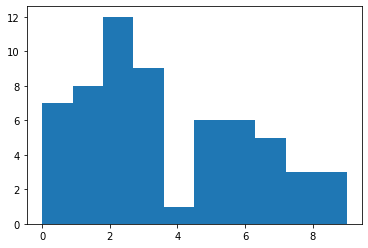

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(in_degree_scores)

### Q5. PageRank
**PageRank**アルゴリズムは「重要なノードから多くのリンクを張られたノードは重要なノードである」との仮定のもと，グラフにおけるノードの中心性を評価する手法である．

Q1で生成したグラフGにPageRankアルゴリズムを適用し，PageRankスコアが高い上位10件のプログラミング言語を表示せよ．

なお，PageRankスコアの計算には``networkx``ライブラリの``pagerank``メソッドは使用しないこと．また，PageRankのダンピングファクター$d$は0.85に設定すること．

In [13]:
def pagerank(G, d=0.85):
    node_num = len(G.nodes)
    M = nx.to_numpy_matrix(G) # 隣接行列
    S = M.T / np.sum(M.T, axis=0) # 推移行列
    S[np.isnan(S)] = 0 # nanをゼロに置換
    v = np.ones((node_num, 1)) / node_num # 固定ベクトル
    r = np.zeros((node_num, 1)) # PageRank初期値
    r[0, 0] = 1
    
    for i in range(100):
        r = d * S * r + (1 - d) * v
    else:        
        #r = r / np.sum(r, axis=0) # 全体で合計値が1になるよう正規化
        return r

In [14]:
scores = pagerank(G)

# プログラミング言語名とスコアを対応させる
scores = {language: scores[i,0] for i, language in enumerate(G.nodes)}

<ipython-input-13-7958b0a6024f>:4: RuntimeWarning: invalid value encountered in true_divide
  S = M.T / np.sum(M.T, axis=0) # 推移行列


In [15]:
print("=" * 30)
print("Top 10 languages with PageRank")
print("=" * 30)
sorted(scores.items(), key=lambda x:-x[1])[:10]

Top 10 languages with PageRank


[('Rust', 0.025414302528014694),
 ('Swift', 0.022409018269060887),
 ('Crystal', 0.020004092674997816),
 ('C#', 0.01771467275029973),
 ('C', 0.013472436930816822),
 ('Hack', 0.013251103839674311),
 ('Java', 0.010599438180346395),
 ('Kotlin', 0.010403157548513968),
 ('Python', 0.00977524587665924),
 ('Dart', 0.0096173507549219)]

#### 検算

In [16]:
print("=" * 30)
print("Top 10 languages with PageRank")
print("=" * 30)
sorted(nx.pagerank(G, alpha=0.85).items(), key=lambda x:-x[1])[:10]

Top 10 languages with PageRank


[('Rust', 0.06689146892450759),
 ('Swift', 0.058977193545621684),
 ('Crystal', 0.05264814722626078),
 ('C#', 0.0466214851053901),
 ('C', 0.035459659857997025),
 ('Hack', 0.034877416941987635),
 ('Java', 0.027898045373197858),
 ('Kotlin', 0.027381529847930755),
 ('Python', 0.025728662782130617),
 ('Dart', 0.025313211090276955)]

### Q6. HITSアルゴリズム
**HITS**アルゴリズムは，グラフ中のノードの
* Hub値: Authority値の高いノードへの参照度
* Authority値: Hub値の高いページからの被参照度

を評価するアルゴリズムである．

Q1で生成したグラフGにHITSアルゴリズムを適用し，Authorityスコアが高い上位10件のプログラミング言語，Hubスコアが高い上位10件のプログラミング言語を表示せよ．

なお，Authority/Hubスコアの計算には``networkx``ライブラリの``hits``メソッドは使用しないこと．

In [17]:
def hits(G):
    node_num = len(G)
    A = nx.to_numpy_matrix(G) # 隣接行列
    
    auths = np.ones((node_num, 1))
    hubs = np.ones((node_num, 1))
    
    for i in range(100):
        auths = A.T * hubs
        auths = auths / np.sum(auths, axis=0)

        hubs = A * auths
        hubs = hubs / np.sum(hubs, axis=0)
    
    return (auths, hubs)

In [18]:
auths, hubs = hits(G)

# プログラミング言語名とスコアを対応させる
auths = {language: auths[i,0] for i, language in enumerate(G.nodes)}
hubs = {language: hubs[i,0] for i, language in enumerate(G.nodes)}

In [19]:
print("=" * 30)
print("Top 10 languages with Authority")
print("=" * 30)
sorted(auths.items(), key=lambda x:-x[1])[:10]

Top 10 languages with Authority


[('D', 0.048410687515489735),
 ('Python', 0.04840447521717473),
 ('Ruby', 0.04800544210228559),
 ('JavaScript', 0.046187901415317624),
 ('Java', 0.04488745898807249),
 ('C#', 0.043775945873889104),
 ('Raku', 0.03845917026261152),
 ('Perl', 0.03767833132602789),
 ('ECMAScript', 0.03690775586310522),
 ('F#', 0.032628017574143235)]

In [20]:
print("=" * 30)
print("Top 10 languages with Hub")
print("=" * 30)
sorted(hubs.items(), key=lambda x:-x[1])[:10]

Top 10 languages with Hub


[('C', 0.07372327764918067),
 ('Python', 0.07110623538357355),
 ('C++', 0.0694038459335454),
 ('Java', 0.06936362406001176),
 ('LISP', 0.06078970118048616),
 ('Haskell', 0.05279216195552767),
 ('Smalltalk', 0.050932766627398096),
 ('C#', 0.05085684726181158),
 ('Perl', 0.04286836059458384),
 ('Eiffel', 0.03712339620034196)]

#### 検算

In [21]:
hubs, auths = nx.hits(G)

print("=" * 30)
print("Top 10 languages with Authority")
print("=" * 30)
sorted(auths.items(), key=lambda x:-x[1])[:10]

Top 10 languages with Authority


[('D', 0.04841068753789012),
 ('Python', 0.04840447520704811),
 ('Ruby', 0.04800544207760397),
 ('JavaScript', 0.04618790139031931),
 ('Java', 0.04488745900942763),
 ('C#', 0.0437759458947372),
 ('Raku', 0.03845917026739673),
 ('Perl', 0.0376783313017523),
 ('ECMAScript', 0.03690775585684114),
 ('F#', 0.03262801761256082)]

In [22]:
print("=" * 30)
print("Top 10 languages with Hub")
print("=" * 30)
sorted(hubs.items(), key=lambda x:-x[1])[:10]

Top 10 languages with Hub


[('C', 0.07372327764106187),
 ('Python', 0.07110623537559249),
 ('C++', 0.06940384592705025),
 ('Java', 0.06936362407597477),
 ('LISP', 0.06078970111551734),
 ('Haskell', 0.05279216198170378),
 ('Smalltalk', 0.050932766630406),
 ('C#', 0.05085684730167392),
 ('Perl', 0.04286836057805613),
 ('Eiffel', 0.03712339620298451)]

### Q7. Biased PageRank（Topic-sensitive PageRank）
**Biased PageRank（Topic-sensitive PageRank）**は，PageRankアルゴリズムにおいてランダムジャンプ成分を一様分布としていたところを，特定ノードの重みの調整することで，が特定ノードにジャンプしやすいランダムサーファーを仮定してPageRankを適用するアルゴリズムである．

今，ユーザXはJavaScript，Perl，PHPを好んで利用しているが，新しいプログラミングを習得したいと考えているとする．Q1で生成したグラフGに対してBiased PageRank（Topic-sensitive PageRank）を適用することで，ユーザXに推薦するプログラミング言語の上位10件を求めよ．

なお，PageRankスコアの計算には``networkx``ライブラリの``pagerank``メソッドは使用しないこと．また，PageRankのダンピングファクター$d$は0.85に設定せよ．

In [23]:
def biased_pagerank(G, d=0.85, biased_nodes=[]):
    node_num = len(G.nodes)
    
    M = nx.to_numpy_matrix(G) # 隣接行列
    S = M.T / np.sum(M.T, axis=0) # 推移行列
    S[np.isnan(S)] = 0 # nanをゼロに置換
    
    if not biased_nodes:
        v = np.ones((node_num, 1)) / node_num # 固定ベクトル
    else:
        v = np.zeros((node_num, 1))        
        node_list = list(G.nodes)
        
        for bn in biased_nodes:
            v[node_list.index(bn), 0] = 1
        v = v / len(biased_nodes)
        
    r = np.zeros((node_num, 1)) # PageRank初期値
    r[0, 0] = 1
    
    for i in range(100):
        r = d * S * r + (1 - d) * v
    else:        
        #r = r / np.sum(r, axis=0) # 全体で合計値が1になるよう正規化
        return r

In [24]:
biased_nodes = ["JavaScript", "Perl", "PHP"]
scores = biased_pagerank(G, biased_nodes=biased_nodes)

# プログラミング言語名とスコアを対応させる
scores = {language: scores[i,0] for i, language in enumerate(G.nodes) if language not in biased_nodes}

<ipython-input-23-72a6b31c372d>:5: RuntimeWarning: invalid value encountered in true_divide
  S = M.T / np.sum(M.T, axis=0) # 推移行列


In [25]:
print("=" * 30)
print("Top 10 languages with PageRank")
print("=" * 30)
sorted(scores.items(), key=lambda x:-x[1])[:10]

Top 10 languages with PageRank


[('Hack', 0.04871846956628216),
 ('Kotlin', 0.025742562918371712),
 ('Dart', 0.024650210348271567),
 ('Raku', 0.008792210897094681),
 ('ECMAScript', 0.007708695983961857),
 ('Ruby', 0.007701437121788978),
 ('Python', 0.007628559347673177),
 ('Swift', 0.0043098972813207514),
 ('Rust', 0.0037791179503333474),
 ('Crystal', 0.003277066063440244)]

#### 検算

In [26]:
scores = nx.pagerank(G, personalization={"JavaScript":1, "Perl":1, "PHP":1})
del scores['JavaScript']
del scores['Perl']
del scores['PHP']

print("=" * 30)
print("Top 10 languages with PageRank")
print("=" * 30)
sorted(scores.items(), key=lambda x:-x[1])[:10]


Top 10 languages with PageRank


[('Hack', 0.15478552502390996),
 ('Kotlin', 0.0817876015708951),
 ('Dart', 0.0783173051626074),
 ('Raku', 0.027933972693326297),
 ('ECMAScript', 0.024491767524390175),
 ('Ruby', 0.024468695036854653),
 ('Python', 0.024237423880882923),
 ('Swift', 0.013693620551382596),
 ('Rust', 0.01200708510525448),
 ('Crystal', 0.010411902467163017)]

### Q8. 媒介中心性

グラフ上で，あるノードが他のノード間の最短経路上に位置する度合いは**媒介中心性**と呼ばれる．
媒介中心性の高いノードは，グラフにおけるあるグループとあるグループをつなぐ（分ける）重要なノードと考えることができる．

Q1で生成したグラフG上の全ノードの媒介中心性を計算し，媒介中心性スコアが高い上位10件のプログラミング言語を表示せよ．

なお，この課題については，媒介中心性を計算するアルゴリズムを自力で実装する必要はない．

In [27]:
betweenness_centrality = nx.betweenness_centrality(G)

print("=" * 30)
print("Top 10 languages with betweenness centrality")
print("=" * 30)
sorted(betweenness_centrality.items(), key=lambda x:-x[1])[:10]

Top 10 languages with betweenness centrality


[('Java', 0.12792852968189028),
 ('C#', 0.10538137912480401),
 ('Ada', 0.07131098494336366),
 ('Python', 0.06771775532734037),
 ('C', 0.06634173833180262),
 ('Rust', 0.04158502871243958),
 ('F#', 0.03139002532631989),
 ('Swift', 0.025375024352230664),
 ('C++', 0.024826867236276935),
 ('Erlang', 0.024320572764465212)]

### Q9. コミュニティ発見 by Girvan-Newmanアルゴリズム
Q8で扱った媒介中心性はエッジに対しても定義することができる．すなわち，媒介中心性の高いエッジは，グラフにおけるあるグループとあるグループをつなぐ（分ける）重要なエッジと考えることができる．

Q1で生成したグラフGにおいて，媒介中心性が最大となるエッジを削除する操作を繰り返すことで，グラフGを10つのサブグラフに分割せよ．

なお，この課題では，グラフGは無向グラフとして扱うこと．また，グラフの分割過程でノード数が1のサブグラフが生成された場合は，そのノードを削除せよ．グラフGに含まれるノード数1のサブグラフを削除する際には，以下の``remove_small_components``関数を用いてもよい．

In [28]:
def remove_small_components(G, min_size=2):
    targets = []
    for component in nx.connected_components(G):
        if len(component) < min_size:
            for node in component:
                targets.append(node)
    else:
        for target in targets:
            G.remove_node(target)
        return G

In [29]:
uG = nx.Graph(G)

while True:
    component_num = nx.number_connected_components(uG)
    if component_num != 9:
        betweennesses = nx.edge_betweenness_centrality(uG)
        edge, betweenness = sorted(betweennesses.items(), key=lambda x:-x[1])[0]
        left_node, right_node = edge
        uG.remove_edge(left_node, right_node)
        
        uG = remove_small_components(uG)
    else:
        break

nx.nx_agraph.view_pygraphviz(uG, prog='fdp') 

for component in nx.connected_components(uG):
    print(component)

{'FORTRAN', 'ALGOL', 'BASIC'}
{'CPL', 'BCPL'}
{'COBOL', 'PL/I', 'B'}
{'Simula', 'Pascal'}
{'ML', 'Haskell', 'Common Lisp', 'Erlang', 'Clojure', 'LISP', 'F#', 'Scala'}
{'APL', 'Forth', 'Mathematica'}
{'C++', 'Python', 'Ada', 'Smalltalk', 'Nim', 'Objective-C', 'C#', 'Crystal', 'Dart', 'Kotlin', 'Java', 'Go', 'JavaScript', 'PHP', 'Swift', 'C', 'ECMAScript', 'D', 'Lua', 'Ruby', 'Scheme', 'Eiffel', 'Perl', 'Rust', 'Raku'}
{'VB.NET', 'Visual Basic'}
{'Hack', 'OCaml'}


### Q10. コミュニティ発見 by スペクトラルクラスタリング
グラフ上の各ノードは，
* 次数（ノードに接続するエッジの数）
* 他ノードとの接続関係の有無の情報

を用いることで，ベクトルとして表現することができる．グラフ上の各ノードの次数の情報を対角成分に格納した行列を**次数行列**，ノード間の関係性の有無を1もしくは0で表した行列を**隣接行列**と呼ばれる．グラフ解析では，グラフ上のノードのベクトルを表現する方法として，次数行列と隣接行列の差である**ラプラシアン行列**が用いられることがある．

例えば，下記のグラフであれば，次数行列$D$および隣接行列$A$は

$$
D =
        \left[\begin{array}{ccccc}
            % 横並びは&を挟む
            1 & 0 & 0 & 0 & 0 \\
            0 & 3 & 0 & 0 & 0 \\
            0 & 0 & 3 & 0 & 0 \\
            0 & 0 & 0 & 2 & 0 \\
            0 & 0 & 0 & 0 & 1 \\
        \end{array}\right] \quad
A =
        \left[\begin{array}{ccccc}
            % 横並びは&を挟む
            0 & 1 & 0 & 0 & 0 \\
            1 & 0 & 1 & 1 & 0 \\
            0 & 1 & 0 & 1 & 1 \\
            0 & 1 & 1 & 0 & 0 \\
            0 & 0 & 1 & 0 & 0 \\
        \end{array}\right] \quad        
$$

となり，ラプラシアン行列$L$は
$$
L = D - A =
        \left[\begin{array}{ccccc}
            % 横並びは&を挟む
            1 & -1 & 0 & 0 & 0 \\
            -1 & 3 & -1 & -1 & 0 \\
            0 & -1 & 3 & -1 & -1 \\
            0 & -1 & -1 & 2 & 0 \\
            0 & 0 & -1 & 0 & 1 \\
        \end{array}\right] \quad      
$$

となる（行列の各行，各列はグラフ中のノードに対応）．ラプラシアン行列$L$を用いれば，例えばノード1のベクトル$v_1$は$v_1=(-1,3,-1,-1,0)$として表現することができる．

さて，[スペクトラルクラスタリング解説](https://qiita.com/sakami/items/9b3d57d4be3ff1c70e1d)でも解説されているように，$L$の（ゼロを除く）小さい固有値に対応する固有ベクトルを用いてグラフのノードをクラスタリングする手法は**スペクトラルクラスタリング**と呼ばれる．

Q1で生成したグラフG上の各ノードをベクトル化するために，グラフGのラプラシアン行列を求め，その固有値および固有ベクトルを求めよ．さらに，小さい固有値に対応する（いくつかの）固有ベクトルに対して階層的クラスタリングを適用し，クラスタ併合過程をデンドログラムで可視化せよ．

なお，この課題ではグラフGを無向グラフとして扱うこと．固有値計算，階層的クラスタリングには外部ライブラリを用いてもよい．

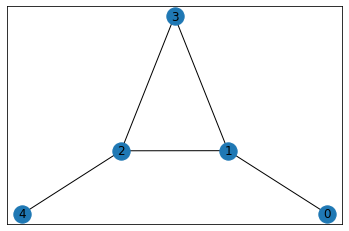

In [30]:
sample_G = nx.Graph()
sample_G.add_edge(0, 1)
sample_G.add_edge(1, 2)
sample_G.add_edge(1, 3)
sample_G.add_edge(3, 2)
sample_G.add_edge(2, 4)
nx.draw_networkx(sample_G)

In [31]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

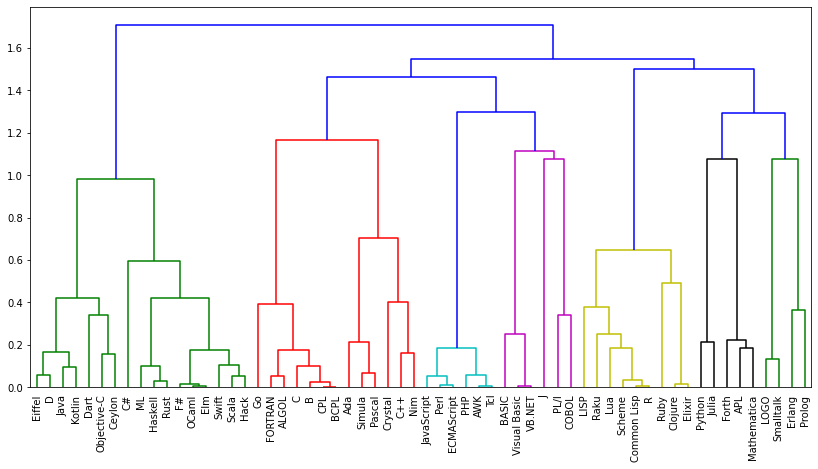

In [32]:
uG = nx.Graph(G)
L = nx.laplacian_matrix(uG).toarray()
eigen_values, eigen_vectors = np.linalg.eig(L)
eigen_ranks = np.argsort(eigen_values) # 固有値の昇順ランキング
_eigen_values = eigen_values[eigen_ranks]
_eigen_vectors = eigen_vectors[:, eigen_ranks]

dimension_num = 10
L_ = _eigen_vectors[:, 1:dimension_num+1]

Z = linkage(L_, method='complete', metric="cosine")
fig = plt.figure(figsize=(14, 7))
dendrogram(Z, labels=list(G.nodes))
plt.tick_params(labelsize=10)
plt.show()